# ライブラリとデータの読み込み

In [ ]:
!pip install japanize-matplotlib
!pip install pandas-ta
!pip install optuna
# pandas-taが最新のnumpyに対応していないためダウングレード
!pip install "numpy<2.0"

In [ ]:
# ライブラリの読み込み
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import pandas_ta as ta
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score
import optuna
from optuna.samplers import TPESampler
import pandas as pd
import yfinance as yf

In [ ]:
# データの読み込み
df = pd.read_csv('stock_price.csv')

# データの概観と前処理

まずデータを大まかに把握する。

欠損値の有無やデータ型等を確認し、str型の数値データをfloatにするなどしてEDAを行うための最低限の前処理を行う。

In [ ]:
df.head()

,日付け,終値,始値,高値,安値,出来高,変化率 %
0,2024-08-01,156.3,159.3,159.4,156.1,79.15M,-2.56%
1,2024-07-31,160.4,158.2,160.7,158.1,173.91M,1.07%
2,2024-07-30,158.7,158.8,159.2,158.0,138.14M,-0.63%
3,2024-07-29,159.7,158.7,160.2,158.4,126.28M,1.14%
4,2024-07-26,157.9,159.3,159.6,157.9,155.08M,-0.13%


変化率の定義を確認する

In [ ]:
(df['終値']/df['終値'].shift(-1)-1).head()

,終値
0,-0.025561
1,0.010712
2,-0.006262
3,0.011400
4,-0.001265


　以上より、変化率 %の列は、当日の終値と前日の終値の差をで割り、四捨五入した値を百分率で表した値であるとわかる。四捨五入する前の正確な値を用いる方が望ましいため、変化率の列を定義しなおす。ただしもっとも古い日付の値が欠損するので、元の変化率 %列の値を用いる。同時に百分率ではなく比率で表すことにする。


In [ ]:
old_value = list(df['変化率 %'])[-1]
old_value = float(old_value.strip('%'))/100
df.drop('変化率 %', axis=1, inplace=True)
df['変化率'] = df['終値']/df['終値'].shift(-1)-1
df.iloc[-1, df.columns.get_loc('変化率')] = old_value

In [ ]:
print('データの行数:',len(df))

データの行数: 9202


In [ ]:
# 欠損値の確認
df.isnull().sum()

,0
日付け,0
終値,0
始値,0
高値,0
安値,0
出来高,0
変化率,0


In [ ]:
# 型の確認
df.dtypes

,0
日付け,object
終値,float64
始値,float64
高値,float64
安値,float64
出来高,object
変化率,float64


In [ ]:
# 出来高の表記を確認
set(df['出来高'].apply(lambda x: x[-1]))

{'B', 'M'}

In [ ]:
# 出来高をfloatに、ただしMを最小単位とする(B=1000M)
df['出来高'] = df['出来高'].apply(lambda x: float(x.strip('M')) if x[-1]=='M' else float(x.strip('B'))*(10**3))

In [ ]:
# 列名を英語に変更
df.columns = ['Date', 'Close', 'Open', 'High', 'Low', 'Volume', 'Change']

各データをグラフで視覚化し、異常値の有無等を確認する

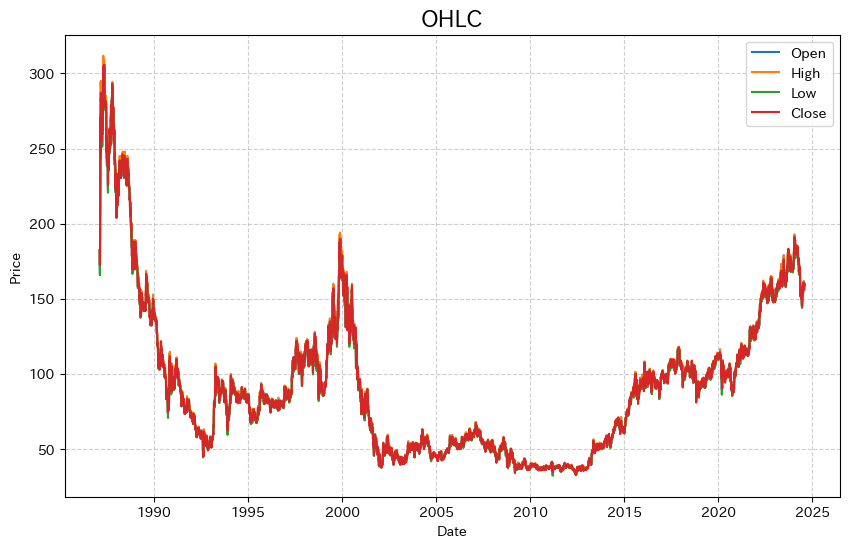

In [ ]:
# 日付列をdatetime型に変換し、ソートする
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# OHLCのグラフを表示
plt.figure(figsize=(10, 6))

for col in ['Open', 'High', 'Low', 'Close']:
    plt.plot(df['Date'], df[col], marker='', linestyle='-', label=col)

plt.title('OHLC', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

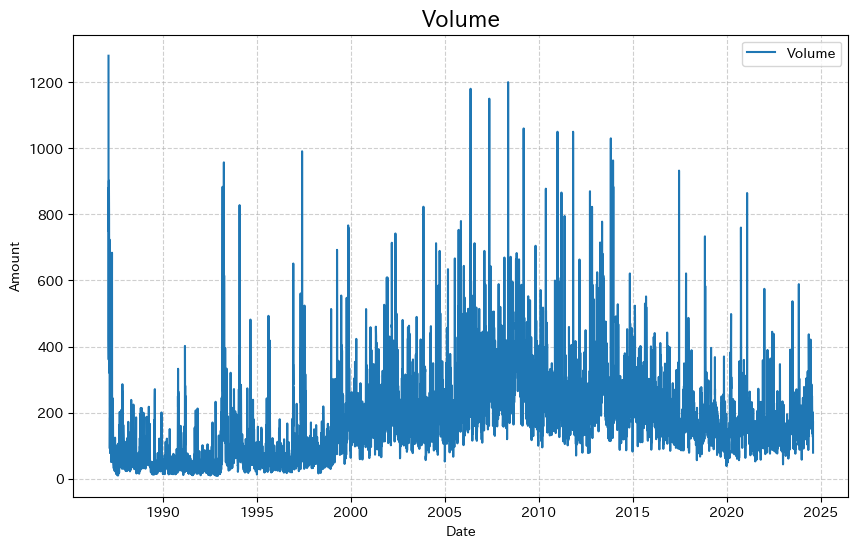

In [ ]:
# Volumeのグラフを表示
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Volume'], marker='', linestyle='-', label='Volume')
plt.title('Volume', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Amount')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

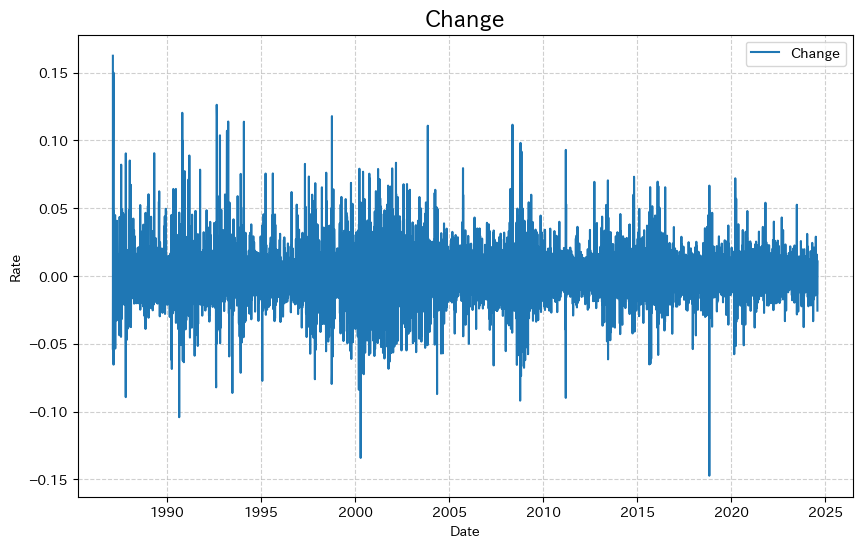

In [ ]:
# Changeのグラフを表示
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Change'], marker='', linestyle='-', label='Change')
plt.title('Change', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Rate')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

　以上のグラフからどの列の値もすべて正常な範囲内であり、明らかにおかしな値（入力ミスなど）はない。また、株式分割も考慮した調整済みの株価データであることがわかる。

# EDAと特徴量エンジニアリング

ここでは、一般的に株価データの解析で用いられる統計量を計算しつつ、それらを視覚化し、本株価データの特徴を掴む。

　株価予測においては株価の絶対値ではなくリターンのような相対値を使うのが一般的である。そこでReturnの性質について視覚化して見ていく。

Changeの平均: 0.00017479895271677794
Changeの標準偏差: 0.018767660902150676
Changeの最大値: 0.1625
vの最小値: -0.1473684210526316


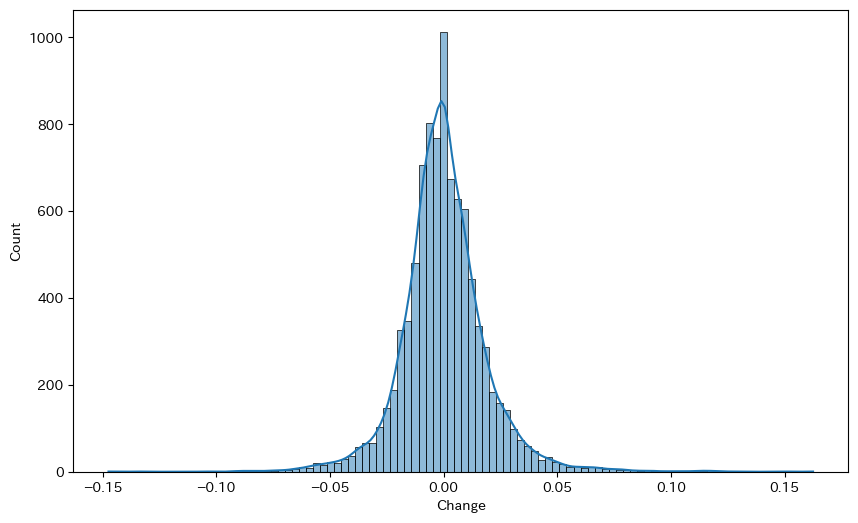

In [ ]:
print('Changeの平均:',df['Change'].mean())
print('Changeの標準偏差:',df['Change'].std())
print('Changeの最大値:',df['Change'].max())
print('vの最小値:',df['Change'].min())

# ヒストグラムで分布を可視化
plt.figure(figsize=(10, 6))
sns.histplot(df['Change'], bins=100, kde=True)
plt.xlabel('Change')
plt.show()

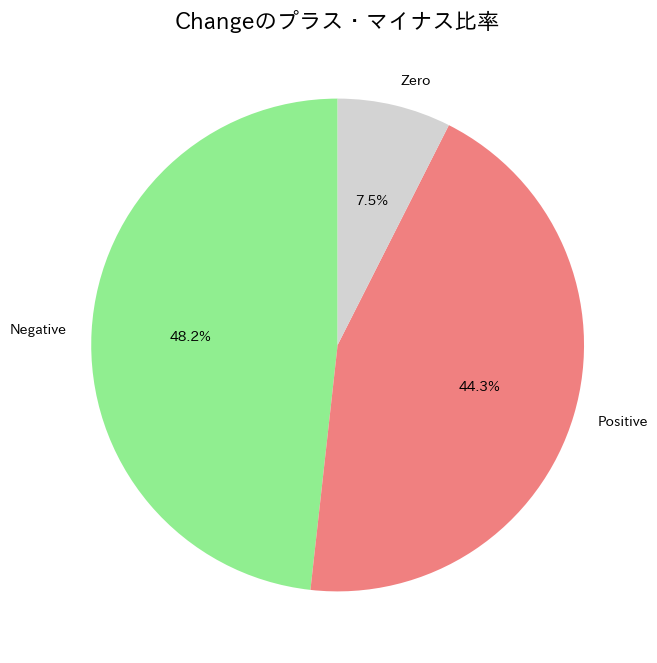

In [ ]:
# Changeがプラスかマイナスかで分類
change_counts = df['Change'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Zero')).value_counts()

# 円グラフで表示
plt.figure(figsize=(8, 8))
plt.pie(change_counts, labels=change_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightcoral', 'lightgray'])
plt.title('Changeのプラス・マイナス比率', fontsize=16)
plt.show()

OpenとCloseの変動率をChange_OCと定義

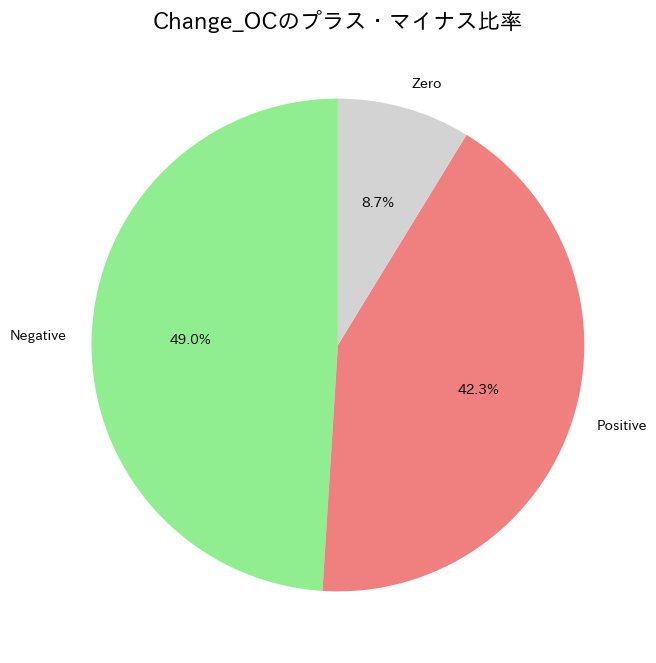

In [ ]:
# OpenからCloseまでの変動率
df['Change_OC'] = (df['Close']-df['Open'])/df['Open']

# 先ほどと同様にChange_OCがプラスかマイナスかで分類
change_counts = df['Change_OC'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Zero')).value_counts()

# 円グラフで表示
plt.figure(figsize=(8, 8))
plt.pie(change_counts, labels=change_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightcoral', 'lightgray'])
plt.title('Change_OCのプラス・マイナス比率', fontsize=16)
plt.show()

Month列を追加し、季節性について確認する。

In [ ]:
df['Month'] = df['Date'].apply(lambda x: x.month)

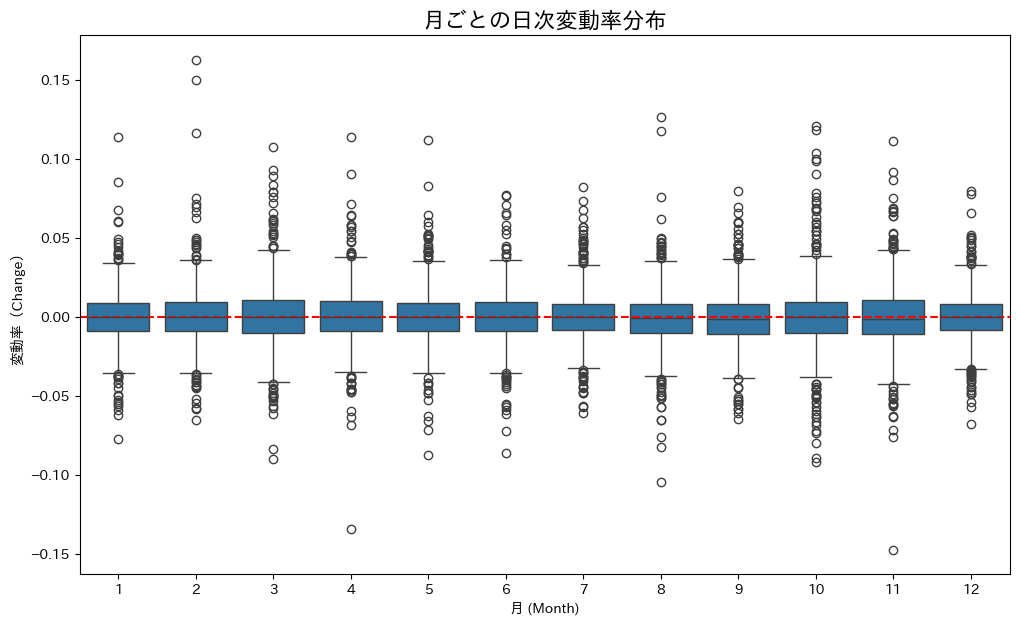

In [ ]:
# 月ごとの日次変動率を箱ひげ図でプロット
plt.figure(figsize=(12, 7))
sns.boxplot(x='Month', y='Change', data=df)
plt.axhline(0, color='red', linestyle='--')
plt.title('月ごとの日次変動率分布', fontsize=16)
plt.xlabel('月 (Month)')
plt.ylabel('変動率（Change）')
plt.show()

　Monthを1から12の数値で表すと12月と1月の連続性を表現できない。そこで、sin変換とcos変換を用いることで連続性を表現する。

In [ ]:
df['Month_sin'] = df['Month'].apply(lambda x: np.sin(2*np.pi*x/12))
df['Month_cos'] = df['Month'].apply(lambda x: np.cos(2*np.pi*x/12))

曜日についても箱ひげ図を使って視覚化する。

In [ ]:
df['Day_of_week'] = df['Date'].dt.dayofweek

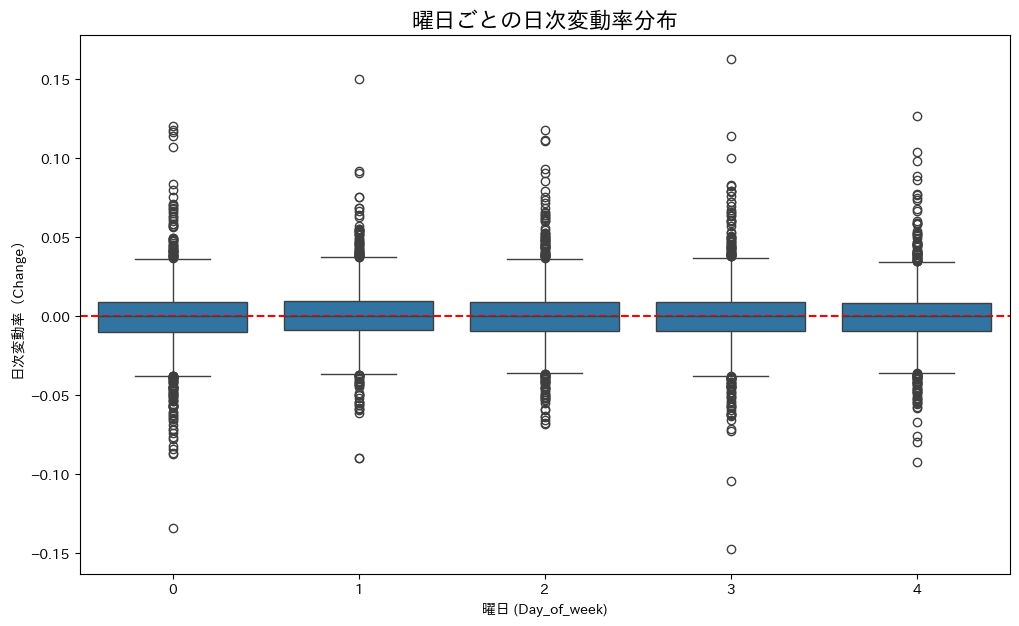

In [ ]:
# 曜日ごとのリターンを箱ひげ図でプロット
plt.figure(figsize=(12, 7))
sns.boxplot(x='Day_of_week', y='Change', data=df)
plt.axhline(0, color='red', linestyle='--')
plt.title('曜日ごとの日次変動率分布', fontsize=16)
plt.xlabel('曜日 (Day_of_week)')
plt.ylabel('日次変動率（Change）')
plt.show()

月や曜日ごとの終値の変化率に明確な特徴は見られない。

pandas_taを用いて移動平均線や一般的なテクニカル指標を計算する。

In [ ]:
# 1. 移動平均線 (SMA: Simple Moving Average)
df.ta.sma(length=20, append=True) # 20日単純移動平均
df.ta.sma(length=50, append=True) # 50日単純移動平均

# 2. RSI (Relative Strength Index - 相対力指数)
df.ta.rsi(length=14, append=True) # 14日間のRSI

# 3. MACD (Moving Average Convergence Divergence)
# fast:短期EMA, slow:長期EMA, signal:シグナル線
df.ta.macd(fast=12, slow=26, signal=9, append=True)

# 4. ボリンジャーバンド (Bollinger Bands)
# length:中心線の期間, std:標準偏差の倍率
df.ta.bbands(length=20, std=2, append=True)

pd.set_option('display.max_columns', None)
df.tail()

,Date,Close,Open,High,Low,Volume,Change,Change_OC,Month,Month_sin,Month_cos,Day_of_week,SMA_20,SMA_50,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0
4,2024-07-26,157.9,159.3,159.6,157.9,155.08,-0.001265,-0.008788,7,-0.500000,-0.866025,4,157.765,153.574,53.386642,1.468375,-0.046403,1.514778,153.500132,157.765,162.029868,5.406609,0.515827
3,2024-07-29,159.7,158.7,160.2,158.4,126.28,0.011400,0.006301,7,-0.500000,-0.866025,0,158.160,153.732,57.971702,1.471290,-0.034790,1.506080,154.813718,158.160,161.506282,4.231514,0.730106
2,2024-07-30,158.7,158.8,159.2,158.0,138.14,-0.006262,-0.000630,7,-0.500000,-0.866025,1,158.285,153.870,54.749681,1.377035,-0.103236,1.480271,155.056208,158.285,161.513792,4.079720,0.564266
1,2024-07-31,160.4,158.2,160.7,158.1,173.91,0.010712,0.013906,7,-0.500000,-0.866025,2,158.495,154.014,58.928787,1.423108,-0.045730,1.468839,155.289708,158.495,161.700292,4.044661,0.797165
0,2024-08-01,156.3,159.3,159.4,156.1,79.15,-0.025561,-0.018832,8,-0.866025,-0.500000,3,158.385,154.050,47.528083,1.115922,-0.282333,1.398255,155.039989,158.385,161.730011,4.223899,0.188342


　これらの指標をもとにゴールデンクロスなどの新たな特徴量を作成する。特に移動平均線（SMA）とボリンジャーバンドのバンド値（BBL, BBM, BBU）は価格そのものであり、そのままでは使えない。

In [ ]:
# 移動平均からの乖離率
df['SMA_20_gap'] = (df['Close']-df['SMA_20'])/df['SMA_20']
df['SMA_50_gap'] = (df['Close']-df['SMA_50'])/df['SMA_50']

# ゴールデンクロス・デッドクロス
df['SMA_cross'] = (df['SMA_20'] > df['SMA_50']).astype(int)

# RSIによって買われすぎ・売られすぎを判定
df['RSI_Zone'] = np.where(df['RSI_14'] > 70, -1, 0)
df['RSI_Zone'] = np.where(df['RSI_14'] < 30, 1, df['RSI_Zone'])

# ボリンジャーバンドの上限・下限と終値の大小関係
df['BB_Zone'] = np.where(df['Close'] > df['BBM_20_2.0'], 1, 0)
df['BB_Zone'] = np.where(df['Close'] < df['BBU_20_2.0'], -1, df['BB_Zone'])

　今回は表データとして学習に用いるため、当日だけでなく過去のデータを参照するには、当日の行に過去データをラグ特徴量として追加する必要がある。そこでリターンや取引量、先ほど追加したテクニカル系の特徴量に関してラグ特徴量の作成を行う。

In [ ]:
# ラグ特徴量を作成する特徴量のリストを定義
lag_features = ['Change', 'Change_OC', 'Volume', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',	'BBB_20_2.0', 'BBP_20_2.0', 'SMA_20_gap', 'SMA_50_gap', 'SMA_cross', 'RSI_Zone', 'BB_Zone']

# 1,2,5日をラグとして特徴量を作成する
for col in lag_features:
    df[col+'_lag1'] = df[col].shift(1)
    df[col+ '_lag2'] = df[col].shift(2)
    df[col+ '_lag5'] = df[col].shift(5)

最後に欠損値がある行を消去する。

In [ ]:
df.dropna(inplace=True)
df

,Date,Close,Open,High,Low,Volume,Change,Change_OC,Month,Month_sin,Month_cos,Day_of_week,SMA_20,SMA_50,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,SMA_20_gap,SMA_50_gap,SMA_cross,RSI_Zone,BB_Zone,Change_lag1,Change_lag2,Change_lag5,Change_OC_lag1,Change_OC_lag2,Change_OC_lag5,Volume_lag1,Volume_lag2,Volume_lag5,RSI_14_lag1,RSI_14_lag2,RSI_14_lag5,MACD_12_26_9_lag1,MACD_12_26_9_lag2,MACD_12_26_9_lag5,MACDh_12_26_9_lag1,MACDh_12_26_9_lag2,MACDh_12_26_9_lag5,MACDs_12_26_9_lag1,MACDs_12_26_9_lag2,MACDs_12_26_9_lag5,BBB_20_2.0_lag1,BBB_20_2.0_lag2,BBB_20_2.0_lag5,BBP_20_2.0_lag1,BBP_20_2.0_lag2,BBP_20_2.0_lag5,SMA_20_gap_lag1,SMA_20_gap_lag2,SMA_20_gap_lag5,SMA_50_gap_lag1,SMA_50_gap_lag2,SMA_50_gap_lag5,SMA_cross_lag1,SMA_cross_lag2,SMA_cross_lag5,RSI_Zone_lag1,RSI_Zone_lag2,RSI_Zone_lag5,BB_Zone_lag1,BB_Zone_lag2,BB_Zone_lag5
9147,1987-04-30,287.3,292.2,292.2,285.3,88.34,0.010552,-0.016769,4,0.866025,-0.500000,3,281.125,271.080,55.521317,8.627000,-0.523905,9.150905,254.648076,281.125,307.601924,18.836407,0.616611,0.021965,0.059835,1,0,-1,-0.016943,-0.032776,-0.012791,-0.006986,-0.032776,-0.028405,199.91,187.61,383.15,53.850599,57.103765,66.733471,9.339859,10.419329,10.063576,0.057978,1.151942,2.245355,9.281882,9.267387,7.818221,18.839766,19.406225,17.614037,0.571236,0.676831,1.039022,0.013421,0.034316,0.094944,0.056257,0.082659,0.158111,1.0,1.0,1.0,0.0,0.0,0.0,-1.0,-1.0,1.0
9146,1987-05-01,299.0,292.2,302.0,289.2,234.25,0.040724,0.023272,5,0.500000,-0.866025,4,282.495,273.138,61.391708,8.903512,-0.197914,9.101427,255.305335,282.495,309.684665,19.249661,0.803516,0.058426,0.094685,1,0,-1,0.010552,-0.016943,0.006312,-0.016769,-0.006986,0.002980,88.34,199.91,172.43,55.521317,53.850599,67.470657,8.627000,9.339859,10.915051,-0.523905,0.057978,2.477464,9.150905,9.281882,8.437587,18.836407,18.839766,19.068382,0.616611,0.571236,0.992214,0.021965,0.013421,0.093857,0.059835,0.056257,0.154714,1.0,1.0,1.0,0.0,0.0,0.0,-1.0,-1.0,-1.0
9145,1987-05-06,299.0,304.9,306.9,298.0,134.82,0.000000,-0.019351,5,0.500000,-0.866025,2,283.570,274.902,61.391708,9.018688,-0.066191,9.084879,255.567350,283.570,311.572650,19.750079,0.775510,0.054413,0.087660,1,0,-1,0.040724,0.010552,-0.012876,0.023272,-0.016769,-0.022556,234.25,88.34,223.28,61.391708,55.521317,64.319931,8.903512,8.627000,11.146661,-0.197914,-0.523905,2.167260,9.101427,9.150905,8.979402,19.249661,18.836407,20.178348,0.803516,0.616611,0.871772,0.058426,0.021965,0.075018,0.094685,0.059835,0.128958,1.0,1.0,1.0,0.0,0.0,0.0,-1.0,-1.0,-1.0
9144,1987-05-07,303.9,303.9,305.9,301.0,180.24,0.016388,0.000000,5,0.500000,-0.866025,3,285.185,276.274,63.717606,9.397032,0.249722,9.147310,256.414857,285.185,313.955143,20.176477,0.825250,0.065624,0.099995,1,0,-1,0.000000,0.040724,-0.032776,-0.019351,0.023272,-0.032776,134.82,234.25,187.61,61.391708,61.391708,57.103765,9.018688,8.903512,10.419329,-0.066191,-0.197914,1.151942,9.084879,9.101427,9.267387,19.750079,19.249661,19.406225,0.775510,0.803516,0.676831,0.054413,0.058426,0.034316,0.087660,0.094685,0.082659,1.0,1.0,1.0,0.0,0.0,0.0,-1.0,-1.0,-1.0
9143,1987-05-08,304.9,305.9,308.8,302.9,243.17,0.003291,-0.003269,5,0.500000,-0.866025,4,286.705,276.960,64.191719,9.666139,0.415063,9.251076,257.151965,286.705,316.258035,20.615640,0.807836,0.063462,0.100881,1,0,-1,0.016388,0.000000,-0.016943,0.000000,-0.019351,-0.006986,180.24,134.82,199.91,63.717606,61.391708,53.850599,9.397032,9.018688,9.339859,0.249722,-0.066191,0.057978,9.147310,9.084879,9.281882,20.176477,19.750079,18.839766,0.825250,0.775510,0.571236,0.065624,0.054413,0.013421,0.099995,0.087660,0.056257,1.0,1.0,1.0,0.0,0.0,0.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2024-07-26,157.9,159.3,159.6,157.9,

# モデルの構築と評価

## モデルの選択
　時系列データの予測に用いられるモデルとしては、ARIMAのような古典的な統計モデルやLSTMのような深層学習モデル、また、GBDTのような表形式のデータ用の機械学習モデルがある。Kaggleなどを見ると、時系列予測のコンペティションにおいて上位のモデルは、主にLSTMなどのRNNを用いるものか、LightGBMのようなGBDTモデルを使ったものが多いようである。\
　私はGBDTモデルを用いることが多く、本格的な深層学習モデルの構築経験は乏しい。そのため、一週間という期限内で精度の高いモデルを構築するためにはLightGBMを用いるのが最善だと判断した。





## 予測対象と評価指標
　株価予測というテーマにおいて、何を予測するかは様々である。今回のデータセットが一日を単位とするものであることから、前日の終値までのデータから、次の日の株価を予測することにする。また、株価予測は一般に難しいタスクとして知られており、次の日の株価そのものを予測するのは困難である。そこで今回は、次の日の終値が始値を上回っているか否かを分類するモデルを構築する。なお、前日の終値ではなく次の日の始値を用いたのは実際の取引を意識してのことである。\
　今回の場合、評価指標の選択肢の幅は広い。EDAにて示されたように株価の変動の正負の確率は五分五分に近い均衡データである。始値で売って終値で売る戦略をとる場合は適合率が重要だと考えられる。しかし、空売りも考慮すると、株価上昇と下降は対称に扱ってよいだろう。今回は汎用性の高いAUCを用いることとするが、用いる取引戦略に応じて他の指標も参考にするとよい。


In [ ]:
# 目的変数の作成
df['Target'] = (df['Close'] >= df['Open']).astype(int)

# 次の日の変動を予測するため、Target列を1日ずらす
df['Target'] = df['Target'].shift(-1)
df.dropna(inplace=True)

# 説明変数と目的変数に分ける
X = df.drop(['Date', 'Open', 'High', 'Low', 'Close', 'SMA_20', 'SMA_50', 'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0', 'Target'], axis=1)
y = df['Target']

## バリデーションとチューニング
　時系列データであるため、通常のクロスバリデーションを用いるのは不適切である。時系列データ用のバリデーションにも様々なものがある。今回は学習データとテストデータのサイズを固定し、期間をずらしていく交差検証法を採用した。

　また、Optunaを用いてベイズ最適化によるハイパーパラメーターチューニングを行う。

## 学習と評価

In [ ]:
# Optunaの目的関数を定義
def objective(trial):
    """Optunaが最適化を行うための目的関数"""

    params = {
        'objective': 'binary',
        'metric': 'auc',
        'random_state': 42,
        'verbose': -1,
        'n_estimators': trial.suggest_int('n_estimators', 200, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 30, 150),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 200),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
    }

    tscv = TimeSeriesSplit(
        n_splits=15,
        max_train_size=1008,  # 学習期間を約4年に固定
        test_size=252         # テスト期間を約1年に固定
    )
    scores = []

    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  eval_metric='auc',
                  callbacks=[lgb.early_stopping(15, verbose=False)])

        # AUC計算のために確率を予測
        preds_proba = model.predict_proba(X_val)[:, 1]
        scores.append(roc_auc_score(y_val, preds_proba))

    return sum(scores) / len(scores)

# Optunaのシード値を固定
sampler = TPESampler(seed=42)

# Optunaによる最適化の実行
study = optuna.create_study(
    direction='maximize',
    sampler=sampler
    )
study.optimize(objective, n_trials=100)


print("\n--- Optunaによるハイパーパラメータチューニング結果 (AUC) ---")
print(f"最高のAUCスコア: {study.best_value:.4f}")
print("最適なハイパーパラメータ:")
print(study.best_params)

[I 2025-07-25 18:41:57,641] A new study created in memory with name: no-name-7496a02b-98cb-4446-afdb-b8856d385c27
[I 2025-07-25 18:41:59,942] Trial 0 finished with value: 0.5313225554870752 and parameters: {'n_estimators': 874, 'learning_rate': 0.08927180304353628, 'num_leaves': 118, 'max_depth': 14, 'min_child_samples': 48, 'feature_fraction': 0.662397808134481, 'bagging_fraction': 0.6232334448672797, 'bagging_freq': 7}. Best is trial 0 with value: 0.5313225554870752.
[I 2025-07-25 18:42:02,963] Trial 1 finished with value: 0.5371606419008331 and parameters: {'n_estimators': 1282, 'learning_rate': 0.051059032093947576, 'num_leaves': 32, 'max_depth': 20, 'min_child_samples': 170, 'feature_fraction': 0.6849356442713105, 'bagging_fraction': 0.6727299868828402, 'bagging_freq': 2}. Best is trial 1 with value: 0.5371606419008331.
[I 2025-07-25 18:42:07,118] Trial 2 finished with value: 0.5320200845046226 and parameters: {'n_estimators': 747, 'learning_rate': 0.03347776308515933, 'num_leaves


--- Optunaによるハイパーパラメータチューニング結果 (AUC) ---
最高のAUCスコア: 0.5416
最適なハイパーパラメータ:
{'n_estimators': 659, 'learning_rate': 0.031345333557230036, 'num_leaves': 111, 'max_depth': 5, 'min_child_samples': 174, 'feature_fraction': 0.6003465490025053, 'bagging_fraction': 0.6604880825367659, 'bagging_freq': 2}


最適なパラメータについて特徴量重要度を確認する。

In [ ]:
# 最適なパラメータを取得
best_params = study.best_params

# --- 特徴量重要度をクロスバリデーションで集計 ---
tscv = TimeSeriesSplit(n_splits=15, max_train_size=1008, test_size=252)
feature_importances = pd.DataFrame(index=X.columns) # 重要度を保存するDataFrame

scores = []
for i, (train_index, val_index) in enumerate(tscv.split(X)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # 最適なパラメータでモデルを学習
    model = lgb.LGBMClassifier(**best_params, random_state=42, importance_type='gain')
    model.fit(X_train, y_train)

    # このFoldでの重要度を保存
    feature_importances[f'fold_{i+1}'] = model.feature_importances_

    # スコアを保存
    preds_proba = model.predict_proba(X_val)[:, 1]
    scores.append(roc_auc_score(y_val, preds_proba))

# 各Foldの重要度の平均と標準偏差を計算
feature_importances['mean'] = feature_importances.mean(axis=1)
feature_importances['std'] = feature_importances.std(axis=1)

# 平均重要度でソートして表示
feature_importances.sort_values('mean', ascending=False)

,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,fold_10,fold_11,fold_12,fold_13,fold_14,fold_15,mean,std
Change,232.513239,239.887929,187.428891,165.654639,169.447049,211.699631,230.695730,384.482040,280.970521,274.549529,295.561749,291.641101,360.752041,313.574389,254.855022,259.580900,62.277436
Volume,162.642440,197.417380,340.434033,201.055355,172.159449,95.676031,179.801809,80.039790,79.619970,119.405851,250.100079,292.868839,262.559679,232.384400,165.810449,188.798370,74.812095
Volume_lag5,110.050569,209.519130,150.662478,202.157090,270.400419,251.701851,248.146531,187.927249,108.903359,128.655120,237.481579,251.508849,164.964290,103.216330,129.257070,183.636794,57.586482
Change_OC_lag1,209.432429,185.643270,171.912700,220.721010,51.875140,66.799700,134.389870,184.049412,210.396400,264.119500,197.102809,191.317149,242.055568,174.481030,205.132730,180.628581,55.902525
Change_OC,251.782320,217.853252,251.901599,157.743100,98.104299,119.993470,178.712089,54.606510,142.797531,127.051890,213.099585,156.153119,147.359131,149.278770,236.890670,166.888489,55.858470
MACDh_12_26_9_lag5,149.975530,145.326159,160.998220,152.070721,84.969191,183.247779,203.779629,108.809140,106.574121,104.014140,259.462629,249.522591,157.181519,169.860969,95.459180,155.416768,50.949899
Change_OC_lag2,202.294570,167.937960,289.340780,160.538061,129.342460,102.054280,104.804990,85.429690,115.032509,192.631480,191.470660,140.987359,176.868510,162.669520,104.669550,155.071492,50.933637
BBB_20_2.0_lag5,196.823591,140.279609,158.603840,210.116891,191.027829,226.809329,216.917680,147.749990,84.035010,154.351050,125.071310,99.879570,166.284600,105.526520,76.330909,153.320515,46.939415
Change_lag1,116.137130,143.600640,191.631390,171.642939,185.386081,134.533371,56.914140,187.349511,212.888792,69.074680,117.787760,117.846899,164.700620,176.729400,229.715121,151.729232,48.136032
Change_lag2,122.354340,152.887510,121.923089,77.804830,37.584510,96.522180,60.527780,60.300089,280.609191,353.103232,246.203629,148.312239,123.522520,154.032071,238.522061,151.613951,87.332169


テクニカル指標よりも、変動率や取引量の重要度が高いことがわかる。

最適なパラメータにおける各foldでのAUCとその標準偏差を確認する。

In [ ]:
print("各foldでのAUC:",*scores)
print("AUCの標準偏差:",np.std(scores))

各foldでのAUC: 0.5300611948772949 0.4981578947368421 0.461740213756475 0.5018848635869912 0.4909606299212598 0.4896595208070618 0.5611688640973631 0.5040739077436325 0.5326369104146882 0.48284576988690214 0.5012712941774726 0.553610918051431 0.4954361054766735 0.47496062992125976 0.46325757575757576
AUCの標準偏差: 0.028796076201950974


AUCが0.5を切っているfoldも多く、このモデルを実用的な取引に用いるのは難しい。

# モデルの改善

## 仮説
　先ほどのモデルではNTTの株価のデータのみを用いて予測を行った。しかし、それだけでは情報量が少なく、高い精度を実現することは難しいだろう。前日の閉場までのデータしか含まれていないため、閉場から次の日の開場までに、国際情勢の動き等があったとしても全く考慮されない。\
　そこで、日本の株式市場が閉場している時間帯に取引されている米国株の情報を追加すれば、これまで考慮できなかった時間帯の情報が含まれているため、予測精度が向上すると考えられる。

## 実装

　Yahoo Finance APIを用いてS&P500の値動きのデータを取得する。元のモデルで重要度の高かった終値の変動率と取引量のデータを用いる。また、ラグ特徴量の計算も行う。

In [ ]:
# S&P500のデータを取得
sp500 = yf.download("^GSPC", period="40y")
sp500.columns = sp500.columns.droplevel(1)

# いくつか有用そうな特徴量を作成
sp500['Change_sp500'] = sp500['Close']/sp500['Close'].shift(1)-1
sp500['Change_sp500_lag1'] = sp500['Change_sp500'].shift(1)
sp500['Change_sp500_lag2'] = sp500['Change_sp500'].shift(2)
sp500['Change_sp500_lag5'] = sp500['Change_sp500'].shift(5)

sp500.rename(columns={'Volume': 'Volume_sp500'}, inplace=True)
sp500['Volume_sp500_lag1'] = sp500['Volume_sp500'].shift(1)
sp500['Volume_sp500_lag2'] = sp500['Volume_sp500'].shift(2)
sp500['Volume_sp500_lag5'] = sp500['Volume_sp500'].shift(5)

# dfと結合
sp500['Date'] = sp500.index
df = pd.merge(df, sp500[['Change_sp500', 'Change_sp500_lag1', 'Change_sp500_lag2', 'Change_sp500_lag5',
                         'Volume_sp500', 'Volume_sp500_lag1', 'Volume_sp500_lag2', 'Volume_sp500_lag5']],
                         left_on='Date', right_index=True, how='left')

/tmp/ipython-input-76-3341302743.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", period="40y")
[*********************100%***********************]  1 of 1 completed


以降は元のモデルと同じ手順で学習と評価を行う。

In [ ]:
# 説明変数と目的変数に分ける
X = df.drop(['Date', 'Open', 'High', 'Low', 'Close', 'SMA_20', 'SMA_50', 'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0', 'Target'], axis=1)
y = df['Target']

# Optunaによる最適化の実行
study = optuna.create_study(
    direction='maximize',
    sampler=sampler
    )
study.optimize(objective, n_trials=100)


print("\n--- Optunaによるハイパーパラメータチューニング結果 (AUC) ---")
print(f"最高のAUCスコア: {study.best_value:.4f}")
print("最適なハイパーパラメータ:")
print(study.best_params)

[I 2025-07-25 18:43:44,072] A new study created in memory with name: no-name-ef2f295e-6aa2-40ff-ac2b-ec0e262d9e19
[I 2025-07-25 18:43:45,046] Trial 0 finished with value: 0.5328139281149006 and parameters: {'n_estimators': 1754, 'learning_rate': 0.042004723167022, 'num_leaves': 70, 'max_depth': 6, 'min_child_samples': 76, 'feature_fraction': 0.7300733288106989, 'bagging_fraction': 0.8918424713352255, 'bagging_freq': 5}. Best is trial 0 with value: 0.5328139281149006.
[I 2025-07-25 18:43:45,865] Trial 1 finished with value: 0.5334485927318965 and parameters: {'n_estimators': 1797, 'learning_rate': 0.029662989987000676, 'num_leaves': 44, 'max_depth': 16, 'min_child_samples': 157, 'feature_fraction': 0.8245108790277985, 'bagging_fraction': 0.9083868719818244, 'bagging_freq': 4}. Best is trial 1 with value: 0.5334485927318965.
[I 2025-07-25 18:43:47,312] Trial 2 finished with value: 0.527040587029004 and parameters: {'n_estimators': 1141, 'learning_rate': 0.026763383567660764, 'num_leaves'


--- Optunaによるハイパーパラメータチューニング結果 (AUC) ---
最高のAUCスコア: 0.5490
最適なハイパーパラメータ:
{'n_estimators': 903, 'learning_rate': 0.03159207393712539, 'num_leaves': 107, 'max_depth': 17, 'min_child_samples': 115, 'feature_fraction': 0.6012618455284333, 'bagging_fraction': 0.9075023712338235, 'bagging_freq': 6}


In [ ]:
# 最適なパラメータを取得
best_params = study.best_params

# --- 特徴量重要度をクロスバリデーションで集計 ---
tscv = TimeSeriesSplit(n_splits=15, max_train_size=1008, test_size=252)
feature_importances = pd.DataFrame(index=X.columns) # 重要度を保存するDataFrame

scores = []
for i, (train_index, val_index) in enumerate(tscv.split(X)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # 最適なパラメータでモデルを学習
    model = lgb.LGBMClassifier(**best_params, random_state=42, importance_type='gain')
    model.fit(X_train, y_train)

    # このFoldでの重要度を保存
    feature_importances[f'fold_{i+1}'] = model.feature_importances_

    # スコアを保存
    preds_proba = model.predict_proba(X_val)[:, 1]
    scores.append(roc_auc_score(y_val, preds_proba))

# 各Foldの重要度の平均と標準偏差を計算
feature_importances['mean'] = feature_importances.mean(axis=1)
feature_importances['std'] = feature_importances.std(axis=1)

# 平均重要度でソートして表示
feature_importances.sort_values('mean', ascending=False)

,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,fold_10,fold_11,fold_12,fold_13,fold_14,fold_15,mean,std
Change_sp500_lag2,358.759266,405.546511,618.347736,682.940521,681.987717,535.978390,637.852945,569.708329,526.154458,397.497974,382.335091,296.427942,362.979262,420.575120,449.728690,488.454664,122.938629
Change_sp500_lag1,272.621324,385.087479,248.554067,298.740806,319.701730,328.485862,421.729296,565.604541,545.011961,608.024717,538.836408,546.450693,702.009185,672.586392,785.713160,482.610508,164.528075
Change_sp500,602.698808,600.945919,529.953611,762.426013,445.025769,322.607357,310.723322,476.056781,442.705176,602.499553,513.332313,490.413951,428.803389,293.208364,310.463123,475.457563,129.143462
Volume_sp500_lag5,432.383574,346.190580,349.190662,516.202806,620.381745,205.710813,354.520554,346.627608,471.046093,527.098541,503.534767,521.265202,352.759619,454.039362,541.367143,436.154605,104.376802
Change_sp500_lag5,377.295252,340.807761,366.816041,305.718501,265.063020,312.025203,334.110882,489.676248,605.565319,544.766460,454.637224,430.916116,422.724377,434.182926,286.936165,398.082766,94.484138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BB_Zone_lag1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BB_Zone_lag2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BB_Zone_lag5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BB_Zone,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
print("各foldでのAUC:",*scores)
print("AUCの標準偏差:",np.std(scores))

各foldでのAUC: 0.5274115197779321 0.5026973684210526 0.4523637794243001 0.5115967030860648 0.454992125984252 0.46601513240857506 0.5550202839756593 0.49522037595432084 0.5489711934156378 0.5045807796802931 0.5174802949402492 0.47475832438238447 0.50697261663286 0.4863622047244094 0.4977272727272728
AUCの標準偏差: 0.029432905721445198


## 結果の分析
　元のモデルのAUCが0.5416だったのに対し、今回のモデルではAUCが0.5490まで上昇している。しかし、trialごとの予測値のブレが大きいことを考慮すると、これだけでは有意な差かはわからない。そこで特徴量重要度を見てみると、S&P500関連の特徴量が上位を占めており、S&P500の情報は予測に有用であったと考えられる。

　やはり、株価予測タスクの困難さとデータ量の少なさから、スコアのブレが大きく、明確にスコアに現れるようなモデルの改善は難しいのだろう。